[*********************100%***********************]  1 of 1 completed

Fetching data from Yahoo! Finance



[*********************100%***********************]  1 of 1 completed


          Date         QQQ         TLT  QQQ_TLT_Ratio
0   2022-01-03  393.079681  129.531723       3.034621
1   2022-01-04  387.981293  128.993164       3.007766
2   2022-01-05  376.062103  128.292953       2.931276
3   2022-01-06  375.797821  128.625092       2.921653
4   2022-01-07  371.726929  127.700478       2.910928
..         ...         ...         ...            ...
817 2025-04-07  423.690002   90.050003       4.705053
818 2025-04-08  416.059998   88.349998       4.709225
819 2025-04-09  466.000000   88.870003       5.243614
820 2025-04-10  446.179993   86.419998       5.162925
821 2025-04-11  454.399994   86.889999       5.229601

[822 rows x 4 columns]


100%|██████████| 703/703 [07:33<00:00,  1.55it/s]


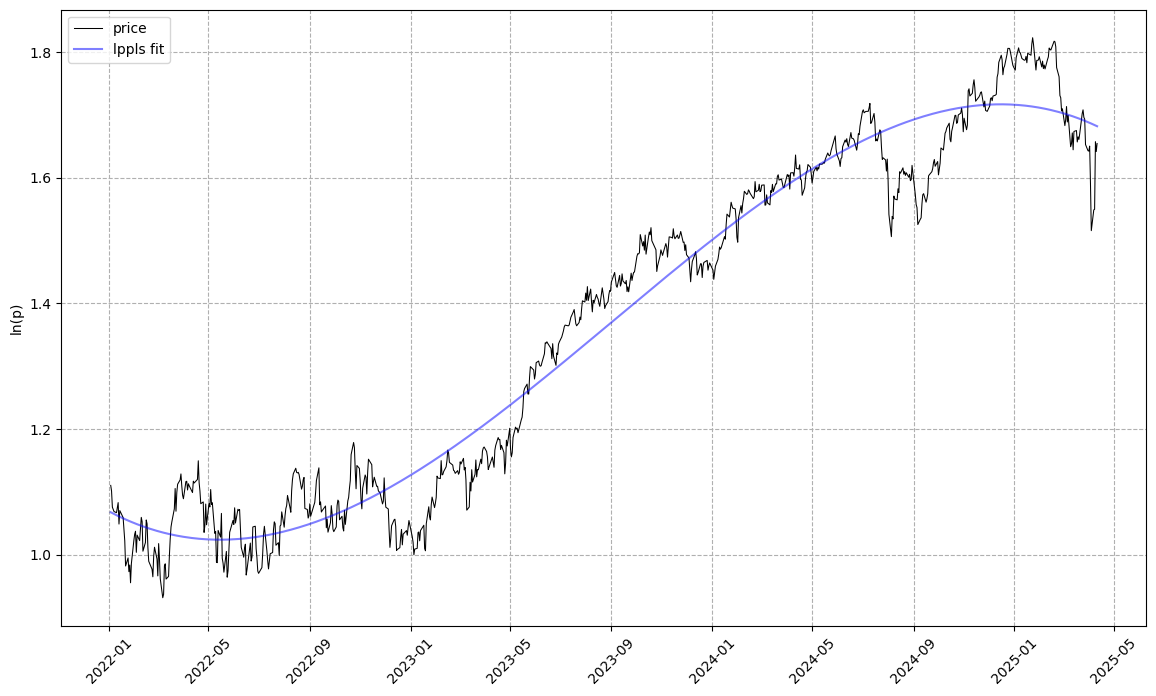

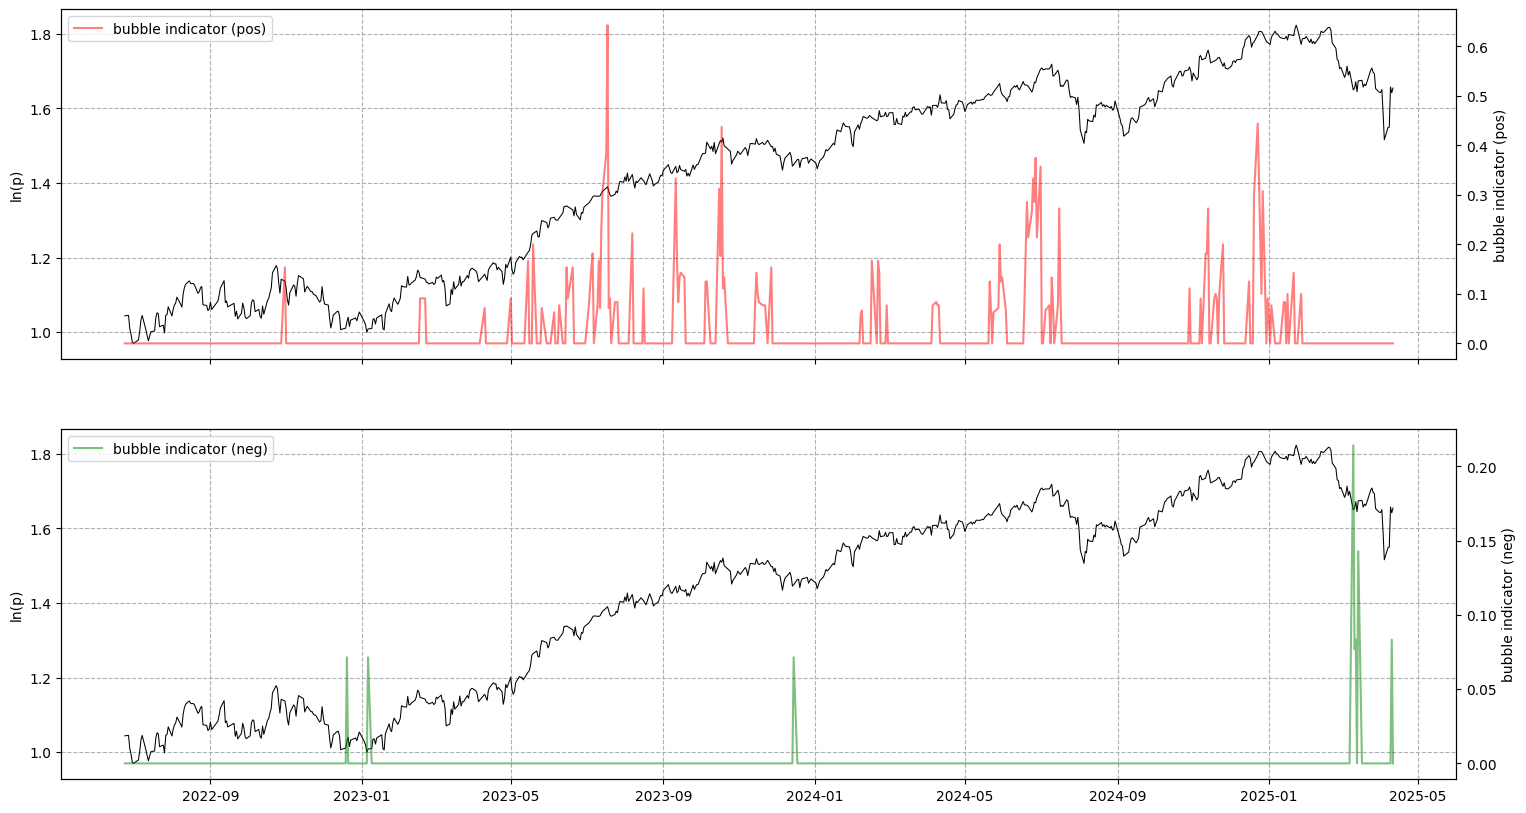

In [2]:
from lppls import lppls, data_loader
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
%matplotlib inline

START = '2022-01-01'
END = '2025-04-14'
LOOKBACK = 21 * 6  # 21 days in a trading month



# Fetch data for QQQ and TLT
print('Fetching data from Yahoo! Finance')
qqq_data = yf.download('QQQ', start=START, end=END)
tlt_data = yf.download('TLT', start=START, end=END)

# Combine and align QQQ and TLT closing prices by date
combined = pd.concat([qqq_data['Close'], tlt_data['Close']], axis=1, join='inner')
combined.columns = ['QQQ', 'TLT']
combined.dropna(inplace=True)

# Calculate QQQ/TLT ratio
combined['QQQ_TLT_Ratio'] = combined['QQQ'] / combined['TLT']


# Reset index to get 'Date' column
combined = combined.reset_index()
print(combined)

# Convert time to ordinal
time = [pd.Timestamp.toordinal(t1) for t1 in combined['Date']]

# Take log of the ratio
price = np.log(combined['QQQ_TLT_Ratio'].values).flatten()

# Create observations array (expected format for LPPLS observations)
observations = np.array([time, price])

# Set max number of searches
MAX_SEARCHES = 25

# Instantiate LPPLS model with the dataset
lppls_model = lppls.LPPLS(observations=observations)

# Fit the model to the data
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)

# Visualize the fit
lppls_model.plot_fit()

# Compute the confidence indicator
res = lppls_model.mp_compute_nested_fits(
    workers=8,
    window_size=120, 
    smallest_window_size=30, 
    outer_increment=1, 
    inner_increment=5, 
    max_searches=25,
)

# Plot confidence indicators
lppls_model.plot_confidence_indicators(res)